# 期望目标模型与球员分析

首先，感谢Alin Secaranu提供了这一出色的数据集。它包括2011年至2016年欧洲五大联赛7000多场比赛的赛事。我一直在尝试获取足球分析方面的见解，但直到现在都找不到合适的数据集。

本报告/笔记的结构如下：

**1. 数据探索**

**2. xG模型（预期目标模型）**

**3. 关于xG模型的结论**

3.a) 我们的模型有多好？

3.b) 我们如何改进我们的模型？


**4. 球员分析**

4.a) 哪些球员是最好的终结者？

4.b) 哪些球员的“预期目标”最多？

4.c) 哪些球员在射门决定方面最差？

4.d) 哪些球员有最好的头球能力？

4.e) 哪些球员最擅长左脚射门？

4.f) 哪些球员最擅长右脚射门？

4.g) 哪些是最好的禁区外射门球员？

4.h) 哪些球员传球最好/最危险？

4.i) 哪些球员威胁传球最多/最少？

4.j) 哪些球员传球时最不走运？

我们将从导入以后可能使用的所有内容开始。

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.ensemble import GradientBoostingClassifier # 梯度提升决策树,GBDT
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, \
recall_score, cohen_kappa_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns # 用于可视化
from datetime import datetime
from sklearn.preprocessing import StandardScaler
pd.options.display.max_columns = 999
pd.options.display.max_rows = 50

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

加载数据

In [2]:
events = pd.read_csv('events.csv')
info = pd.read_csv('ginf.csv')

我们将ginf.csv中的有用信息添加到数据集中，例如联盟/国家和日期。

In [3]:
events = events.merge(info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')

In [4]:
extract_year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
events['year'] = [extract_year(x) for key, x in enumerate(events['date'])]

我们创建一个名为Shots的新数据集，该数据集将包含与比赛相关的所有内容，并排除其余内容。

In [5]:
shots = events[events.event_type==1]
shots['player'] = shots['player'].str.title()
shots['player2'] = shots['player2'].str.title()
shots['country'] = shots['country'].str.title()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

# 1. 数据探索

因为在本文中，我们将专注于分析足球中的射门情况，所以我们将从探索这项运动的一些特点开始。

首先，让我们看看一次射门可能产生的不同结果是如何分布的。

In [6]:
pie = shots[['shot_outcome', 'id_event']].groupby('shot_outcome').count().reset_index().rename(columns={'id_event': 'count'})

In [7]:
pie.shot_outcome = pie.shot_outcome.astype(int)
pie.shot_outcome = pie.shot_outcome.replace({1: 'On Target', 2: 'Off Target', 3: 'Blocked', 4: 'Hit the Bar'})

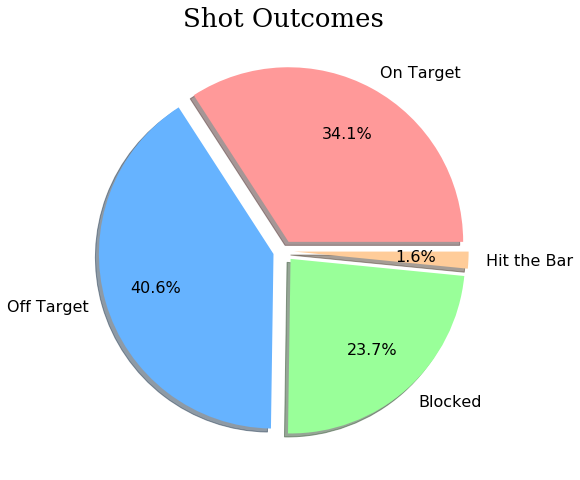

In [8]:
fig, ax = plt.subplots(figsize=[8,8])
labels = pie['shot_outcome']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=pie['count'], autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
       textprops=dict(fontsize=16))
plt.title("Shot Outcomes", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

我们看到大多数射门都偏离了目标，但与目标的差异并不大。当然只有一小部分目标射门最终成为进球，因为守门员试图阻止对方进球。

现在让我们来探索哪些位置适合球员射门。

In [9]:
bar = shots[['shot_place', 'id_event']].groupby('shot_place').count().reset_index().rename(columns={'id_event': 'count'})
bar.shot_place = bar.shot_place.astype(int)
bar.shot_place = bar.shot_place.replace({1: 'Bit too high', 2: 'Blocked', 3: 'Bottom left corner', 4: 'Bottom right corner', \
                                        5: 'Centre of the goal', 6: 'High and wide', 7: 'Hits the bar', 8: 'Misses to the left', \
                                        9: 'Misses to the right', 10: 'Too high', 11: 'Top centre of the goal', \
                                        12: 'Top left corner', 13: 'Top right corner'})

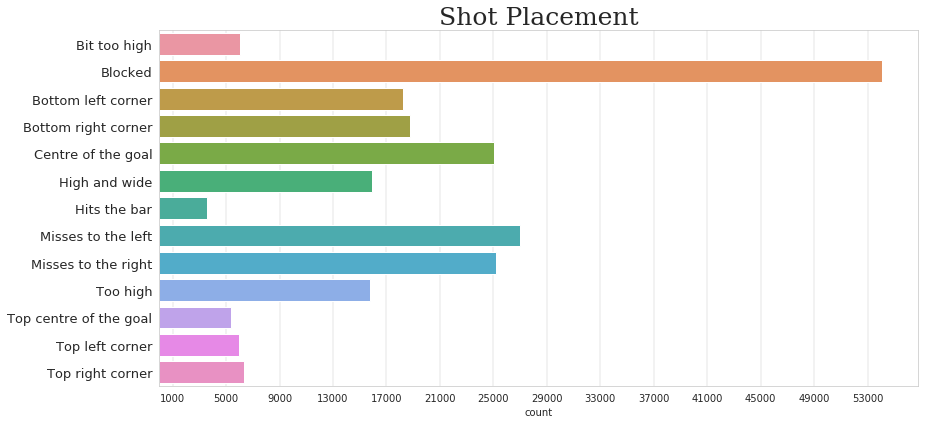

In [10]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[13,6])
labels = bar['shot_place']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(x=bar['count'], y=labels)
ax.set_yticklabels(labels, size = 13)
ax.set_xticks(np.arange(1000,57000,4000))
ax.set_ylabel(ylabel='')
plt.title("Shot Placement", fontsize=25, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

我们发现大多数射门都被对手阻挡，但这是因为所有未被阻挡的射门都分为许多不同的类别。我们在前面的饼图中看到实际上24%的射门确实被阻挡，这仍然是一个相当高的百分比。

从没有被阻挡的射门中，我们可以看到大多数射门要么射向球门中心，要么偏出球门左侧或右侧。

现在，我们将探讨一些对我们的xG模型非常重要的问题——哪些射门最终成为进球。我们将分析拆分为不同的联赛和年份，以检查世界不同地区或不同年份的模型是否存在差异。

In [11]:
goals  = shots[['is_goal', 'id_event', 'country']].groupby(['is_goal', 'country']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [12]:
goals['percentage']=0
for i in range(len(goals)):
    for country in goals.country.unique():
        if goals.iloc[i,goals.columns.get_loc("country")]==country:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.country==country]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

In [13]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y+2, value, ha="center", fontsize=14) 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

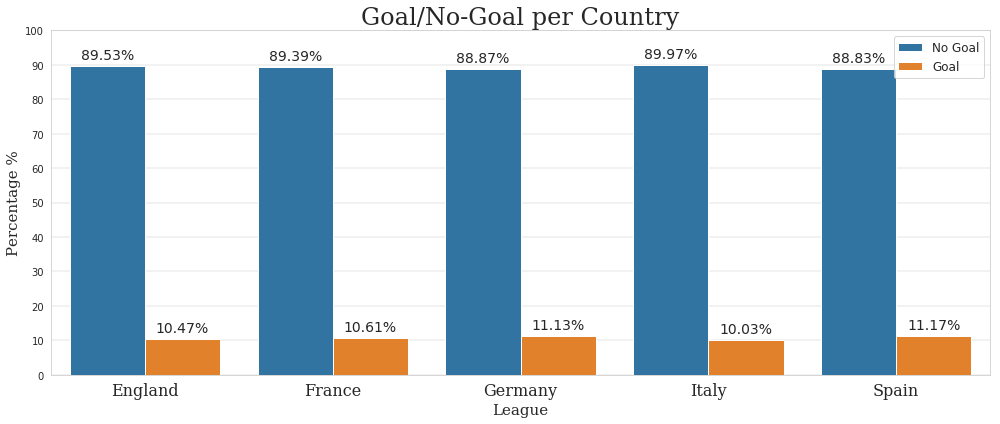

In [14]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='country')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='League', fontsize=15, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Country", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

不同主流联赛之间几乎没有差异，似乎任何一次射门都有10-11%的机会成为进球。

In [15]:
goals  = shots[['is_goal', 'id_event', 'year']].groupby(['is_goal', 'year']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'})

In [16]:
goals['percentage']=0
for i in range(len(goals)):
    for year in goals.year.unique():
        if goals.iloc[i,goals.columns.get_loc("year")]==year:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.year==year]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

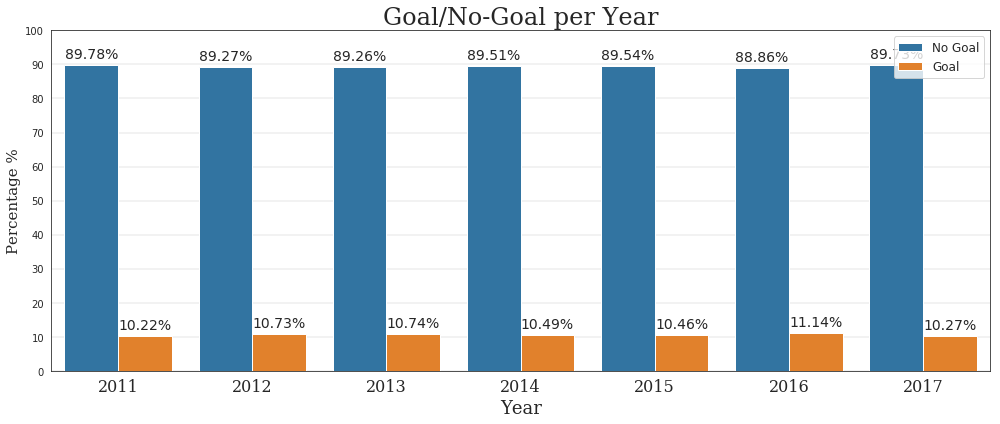

In [17]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='year')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='Year', fontsize=18, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Year", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
show_values_on_bars(ax)
plt.show()

我们发现——（进球/不进球）的比值在时间上几乎相同。

因此从统计学上讲，无论你在什么地方或什么时候看，9到10次射门中有1次是进球。

# 2. xG 模型

在这里我们准备数据，使其适合作为xG模型的输入。首先预期进球是什么。

预期进球模型是一种旨在量化某个射门导致进球的可能性的尝试。有了这个指标，我们可以分析一场比赛中发生了什么，而不是每个队进了多少球。由于比赛是以进球取胜的，而进球只来自射门（除了少数情况下的乌龙球），那么xG指标只需要射门数据。换句话说，任何可能影响一支球队得分多少“预期目标”的事情都必须首先通过更多的射门来实现。例如，有人可能会争辩说，如果B队收到3张红牌，那么A队应该进更多的球（预期目标的增加）。然而，在现实中，有3个以上的球员在场上将导致更多（可能更好）的射门，而更多的射门将导致预期进球的增加。因此，射门及其信息是我们唯一需要考虑的！

xG模型不应考虑干预事件的球员的特定特征或技能。xG模型应该更准确地解释这一点，但我们强烈反对。当然，如果梅西和守门员一对一的话，进球的机会比其他任何球员都高。或者如果曼努埃尔·诺伊尔是守门员，那么进球的概率可能会下降。这不是度量点。我们正试图通过数千个数据点来标准化任何给定球员在特定情况下从特定位置得分的可能性。如果球员是一名出色的终结者，那么他可能会比预期的进球更多，这很好。如果我们开始考虑相关球员的技能，我认为我们在设计这一指标方面走得太远了，而且意义也会降低。

在这个介绍之后，我们准备X和Y集。Y将简单地包括数据库中每次射门，以及它是否是进球（1或0）。它是我们的目标变量。X将在我们的数据中包含所有与射门相关的信息。这将是：

. **位置:** 进攻型半场、防守型半场、禁区中心、左翼、右翼、难角和远距离、左侧难角、右侧难角、禁区左侧、六码禁区左侧、禁区右侧、六码禁区右侧、近距离、罚球点、禁区外、远距离、超过35码、超过40码、没有记录。

. **部位:** 左脚，右脚，头球。

. **方式:** 无、传球、传中、头球传球、传球。

. **情况:** 开球、定位球、角球、任意球。

. **快攻:** 1或0，无论射门是否来自快攻。

因此每一次射门都有很多有意义的信息。射门位置、身体的哪一部分用于射门、如何进行射门（传球后、传中等），以及射门发生的情况或背景（空位、角球等）

由于所有数据都是分类变量，我们必须将它们转换为二进制模型（fast_break除外，它已经是二进制的）。

In [18]:
data = pd.get_dummies(shots.iloc[:,-8:-3], columns=['location', 'bodypart','assist_method', 'situation'])
data.columns = ['fast_break', 'loc_centre_box', 'loc_diff_angle_lr', 'diff_angle_left', 'diff_angle_right',
                'left_side_box', 'left_side_6ybox', 'right_side_box', 'right_side_6ybox', 'close_range',
                'penalty', 'outside_box', 'long_range', 'more_35y', 'more_40y', 'not_recorded', 'right_foot', 
                'left_foot', 'header', 'no_assist', 'assist_pass', 'assist_cross', 'assist_header',
                'assist_through_ball', 'open_play', 'set_piece', 'corner', 'free_kick']
data['is_goal'] = shots['is_goal']

In [19]:
print(len(data))
print(data.is_goal.sum())
print(len(data.columns)-1)

229135
24441
28


所以我们总共有229135次射门，其中24441次是进球。对于每个射门，我们有28个不同的特征来描述它。所有这28个特征都是二进制的，因此它们只是对射门中的某个特征表示是或否。

现在我们将把X和y分成两组，用于训练和测试。使用其中的65%来训练我们的模型，35%用于测试它。因为有足够的数据点，所以65%应该足以正确地训练它，留下尽可能多的射门供以后进行纯测试。

In [20]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

## 梯度提升决策树(GBDT)

我们将首先训练一个梯度提升决策树，这是一个非常强大的算法。它由一组决策树组成。由于这些树往往过度拟合训练数据，因此每次使用不同的预测值和样本开发数千棵不同的树有助于我们在著名的偏差与方差权衡中减少预测的方差。

我们使用hyperopt学习优化模型的最佳hyperparameters。hyperopt比普通的网格搜索更好，因为通过这种方式，我们有一些智能（事实上是另一种算法）试图为模型确定最佳参数。它在我们给它的范围内尝试不同的设置，然后使用最好的的参数设置。

In [21]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

def evaluate_model(params): 
    model = GradientBoostingClassifier(
                        learning_rate=params['learning_rate'],
                        min_samples_leaf=params['min_samples_leaf'],
                        max_depth = params['max_depth'],
                        max_features = params['max_features']
                        )

    model.fit(X_train, y_train)
    return {
        'learning_rate': params['learning_rate'],
        'min_samples_leaf': params['min_samples_leaf'],
        'max_depth': params['max_depth'],
        'max_features': params['max_features'],
        'train_ROCAUC': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        'test_ROCAUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        'recall': recall_score(y_test, model.predict(X_test)),
        'precision': precision_score(y_test, model.predict(X_test)),
        'f1_score': f1_score(y_test, model.predict(X_test)),
        'train_accuracy': model.score(X_train, y_train),
        'test_accuracy': model.score(X_test, y_test),
    }

def objective(params):
    res = evaluate_model(params)
    
    res['loss'] = - res['test_ROCAUC'] # Esta loss es la que hyperopt intenta minimizar
    res['status'] = STATUS_OK # Asi le decimos a hyperopt que el experimento salio bien
    return res 

hyperparameter_space = {
        'learning_rate': hp.uniform('learning_rate', 0.05, 0.3),
        'min_samples_leaf': hp.choice('min_samples_leaf', range(15, 200)),
        'max_depth': hp.choice('max_depth', range(2, 20)),
        'max_features': hp.choice('max_features', range(3, 27))
}

In [22]:
trials = Trials()
fmin(
    objective,
    space=hyperparameter_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
);

100%|██████████| 50/50 [35:25<00:00, 55.37s/it, best loss: -0.8194555116207927]


In [23]:
pd.DataFrame(trials.results).sort_values(by='f1_score', ascending=False).head(5)

,f1_score,learning_rate,loss,max_depth,max_features,min_samples_leaf,precision,recall,status,test_ROCAUC,test_accuracy,train_ROCAUC,train_accuracy
41,0.390448,0.292413,-0.818152,11,19,42,0.710649,0.269167,ok,0.818152,0.910883,0.819175,0.910613
44,0.389868,0.165531,-0.818847,7,8,27,0.715902,0.267874,ok,0.818847,0.911095,0.818531,0.910512
18,0.389657,0.220782,-0.818450,12,23,56,0.710330,0.268462,ok,0.818450,0.910821,0.819041,0.910580
21,0.389508,0.094963,-0.819174,5,26,187,0.718533,0.267168,ok,0.819174,0.911195,0.816901,0.910358
8,0.389379,0.179819,-0.818743,17,5,67,0.716809,0.267286,ok,0.818743,0.911108,0.818711,0.910405


我们使用上面的超参数获得了最佳结果，尽管我们看到在尝试不同的参数值时似乎没有很大的差异。很高兴看到没有任何过度拟合的迹象，因为我们的预测同样适用于训练和测试示例。

In [24]:
model = GradientBoostingClassifier(
                        learning_rate=0.285508,
                        min_samples_leaf=99,
                        max_depth = 19,
                        max_features = 7
                        )
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.285508, loss='deviance', max_depth=19,
              max_features=7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=99, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

让我们更详细地分析模型的性能：

In [25]:
print('The test set contains {} examples (shots) of which {} are positive (goals).'.format(len(y_test), y_test.sum()))
print('The accuracy of classifying whether a shot is goal or not is {}%.'.format(round(model.score(X_test, y_test)*100),2))
print('Our classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100),2))

The test set contains 80198 examples (shots) of which 8504 are positive (goals).
The accuracy of classifying whether a shot is goal or not is 91.0%.
Our classifier obtains an ROC-AUC of 82.0%


因此，我们可以看到，我们的xG模型能够正确预测射门是否为进球**91%**次。此外，我们获得了一个相当好的**ROC-AUC**度量**82%**。这看起来很有希望。

然而，这两个度量并不认为我们的数据集是高度不平衡的。没有进球的射门比射门多得多。因此，举例来说，如果我们简单地预测射门不会每次都是进球，那么我们已经获得了89%的准确率。

因此，我们需要其他指标来真正了解我们的模型是否良好。

现在我们将探讨PR-AUC（Precision-Recall Under the Curve）和科恩的卡帕统计。这两种方法都更适合我们的案例，因为它们确实考虑了我们数据中的不平衡。

In [26]:
print('The baseline performance for PR-AUC is {}%. This is the PR-AUC that what we would get by random guessing.'.format(round(y_train.mean(),2)))
print('Our model obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1])*100,2)))
print('Our classifier obtains a Cohen Kappa of {}.'.format(round(cohen_kappa_score(y_test,model.predict(X_test)),2)))

The baseline performance for PR-AUC is 0.11%. This is the PR-AUC that what we would get by random guessing.
Our model obtains an PR-AUC of 47.35%.
Our classifier obtains a Cohen Kappa of 0.35.


我们用一个混淆矩阵和一个附加的统计报告来结束对模型的评估。

In [27]:
print(color.BOLD + color.YELLOW + 'Confusion Matrix:\n' + color.END)
print(confusion_matrix(y_test,model.predict(X_test)))
print(color.BOLD +  color.YELLOW + '\n Report:' + color.END)
print(classification_report(y_test,model.predict(X_test)))

Confusion Matrix:

[[70786   908]
 [ 6228  2276]]

 Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.71      0.27      0.39      8504

   micro avg       0.91      0.91      0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



混淆矩阵总结了所有预测。它告诉我们，从所有没有进球的射门中，我们的模型正确地识别出70781个没有进球，并在6228个案例中犯了一个错误，在这些案例中，它预测射门不会是进球，但它确实是进球。从另一个专栏中，我们看到它正确预测了913个进球，但未能预测2276次成功射门。

从报告中我们可以看出，该模型在预测第0类（无进球）时有很好的数值，但在预测第1类（进球）时没有那么好。对于后者，我们的准确率为71%，召回率为27%，因此F1得分为0.39。这些数字不错，但不是很好。

这有意义吗？当然有。预测一次射门是否会成为一个进球并且是正确的，比正确预测它不会成为一个进球要困难得多。如果你不知道谁是射门的球员或谁是守门员，这一点尤其正确，而这正是算法所处的情况。这将是一个有趣的人对机器的研究。专家们在判断任何给定的射门是否会成为进球方面是否比像这样的模型要好得多？

## 逻辑回归

In [28]:
model = LogisticRegression(max_iter=400)
model.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=400, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [29]:
print('The test set contains {} examples (shots) of which {} are positive (goals).'.format(len(y_test), y_test.sum()))
print('The accuracy of classifying whether a shot is goal or not is {}%.'.format(round(model.score(X_test, y_test)*100),2))
print('Our classifier obtains an ROC-AUC of {}%'.format(round(roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])*100),2))

The test set contains 80198 examples (shots) of which 8504 are positive (goals).
The accuracy of classifying whether a shot is goal or not is 91.0%.
Our classifier obtains an ROC-AUC of 82.0%


In [30]:
print('The baseline performance for PR-AUC is {}%. This is the PR-AUC that what we would get by random guessing.'.format(round(y_train.mean(),2)))
print('Our model obtains an PR-AUC of {}%.'.format(round(average_precision_score(y_test, model.predict_proba(X_test)[:, 1])*100,2)))
print('Our classifier obtains a Cohen Kappa of {}.'.format(round(cohen_kappa_score(y_test,model.predict(X_test)),2)))

The baseline performance for PR-AUC is 0.11%. This is the PR-AUC that what we would get by random guessing.
Our model obtains an PR-AUC of 47.08%.
Our classifier obtains a Cohen Kappa of 0.35.


In [31]:
print(color.BOLD + color.YELLOW + color.UNDERLINE + 'Confusion Matrix:\n' + color.END)
print(confusion_matrix(y_test,model.predict(X_test)))
print(color.BOLD +  color.YELLOW + color.UNDERLINE + '\n Report:' + color.END)
print(classification_report(y_test,model.predict(X_test)))

Confusion Matrix:

[[70820   874]
 [ 6265  2239]]

 Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.72      0.26      0.39      8504

   micro avg       0.91      0.91      0.91     80198
   macro avg       0.82      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



我们得到的结果与梯度增强几乎完全相同。在这种情况下，人们通常应该选择更简单的模型，在这种情况下是逻辑回归。然而，有39个目标被梯度提升正确识别，而逻辑回归没有捕捉到。即使这不是一个很大的区别，我还是会选择梯度增强。

In [32]:
model = GradientBoostingClassifier(
                        learning_rate=0.285508,
                        min_samples_leaf=99,
                        max_depth = 19,
                        max_features = 7
                        )
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.285508, loss='deviance', max_depth=19,
              max_features=7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=99, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

## 特征重要性
让我们来看看哪些特性与模型更相关，以决定每一个射门是否是一个进球。

In [33]:
import eli5 # ELI5 是一个 Python 软件包，可帮助调试机器学习分类器并解释其预测
eli5.explain_weights(model, feature_names=list(X_train.columns))

Weight,Feature
0.1933 ± 0.1270,close_range
0.1705 ± 0.0825,not_recorded
0.1504 ± 0.1156,outside_box
0.1483 ± 0.0680,penalty
0.0611 ± 0.1698,fast_break
0.0547 ± 0.1122,open_play
0.0453 ± 0.1556,loc_centre_box
0.0335 ± 0.0636,assist_through_ball
0.0202 ± 0.0599,left_side_box
0.0183 ± 0.1449,assist_cross


我们看到，正如预期的那样，大多数射门位置（近距离、禁区中心、禁区外部）都是最相关的。需要担心的一件事是位置的高系数=未记录。显然，有些射门的位置还没有被记录下来，出于某种原因，这些射门极有可能是进球。这使模型更容易实现。为了更好地理解模型，删除这些行并检查其性能可能会很有趣。我已经试过了，结果性能略有下降（ROC-AUC=0.806，PR-AUC=0.41），所以没有太大的差异。不管怎样，我将留下这些行，因为我将在稍后进行球员分析，我不希望有关于球员进球的有价值的信息被删除。

# 3. 关于xG模型的结论

## 3.a) 我们的模型有多好？

很难确定这个模型是否良好，因为没有太多可比较的。我认为科恩的Kappa和PR-AUC PR是我们衡量其表现的最佳指标，但要找到其他不同xG模型的这些数字进行比较并不容易。许多人报告了按季节汇总的**R2**数据，但这没有多大意义。在第4节中，我们将看到我们的模型得出运动员的总预期目标和实际目标之间的相关性为**0.97**，这表明该模型可能足够好，但这一指标也不理想。

在搜索其他xG模型以及它们的表现时，为了能够比较这有多好，我在其他模型中发现了以下关于AUC-ROC的内容（参见[此处](http://business-analytic.co.uk/blog/assessing-expected-goals-models-part-2-anatomy-of-a-big-chance/)):

. Standard Model: ROC-AUC = 79.8%

. Big Chance Model: ROC-AUC = 75.1%

. Standard+Big Chance: ROC-AUC = 82%

. Standard+Defensive = ROC-AUC = 81.4%

然后我们可以将这个模型与其他模型进行比较，至少在这个统计数据上，正如我之前提到的，我认为这不是决定模型性能的最佳方法。

我们的模型的ROC-AUC为**81.9%**，这表明它相当不错，至少与那些模型相比是如此。

## 3.b) 我们怎么提升xG模型?

我用不同的超参数尝试了不同的算法，结果变化不大。

但是，我们可以添加哪些额外的数据来改进我们的模型？首先，有关于防守队的信息会很好。在球门和持球球员之间有多少后卫？运动员能承受多大的防守压力？运动员有多少时间/空间来射门？我想这些问题的（量化的）答案可以给模型提供有趣的新信息，作为其预测的基础。

此外，我们将射门的位置分为17个不同的类别。这很好，但最好是有运动员所在位置的精确x和y坐标。这可能会使每次射门的位置更加精确，从而使模型的预测更加精确。

# 4. 球员分析

首先，我们将在原始数据中的每个射门中添加有关预期目标的信息。从那里，我们可以提取出许多关于玩家的有趣指标，所有这些指标都以某种方式与每次射门的新xG预测相关。

In [34]:
shots['prediction'] = model.predict_proba(X)[:, 1]
shots['difference'] = shots['prediction'] - shots['is_goal']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


## 3.a) 最好的终结者是谁?

通过观察球员进球数和预期进球数之间的差异，我们可以看出谁最擅长完成比赛。我们可以从两个不同的角度来处理这个问题：

1-看看总进球数和总预期进球数之间的差异：这将告诉我们与预期进球数相比，哪个球员的进球数最高。

2-看看总进球数和总预期进球数之间的比率：这将准确地告诉我们球员在每个他应该进球的进球数之间的关系。

In [35]:
players = shots.groupby('player').sum().reset_index()
players.rename(columns={'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
players.expectedGoals = round(players.expectedGoals,2)
players.difference = round(players.difference,2)
players['ratio'] = players['trueGoals'] / players['expectedGoals']

In [36]:
print(round(players.expectedGoals.corr(players.trueGoals),3))

0.977


如上所述，我们看到*trueGoals*和*expectedGoals*之间的相关性非常高，这很好地说明了我们的xG模型。

### 最好的终结者

In [37]:
show = players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'difference', 'trueGoals', 'expectedGoals']].head(10)
show.head(5)

,rank,player,difference,trueGoals,expectedGoals
0,1,Lionel Messi,-58.87,205,146.13
1,2,Zlatan Ibrahimovic,-33.71,153,119.29
2,3,Cristiano Ronaldo,-32.27,198,165.73
3,4,Luis Suarez,-31.66,96,64.34
4,5,Gonzalo Higuain,-31.61,118,86.39


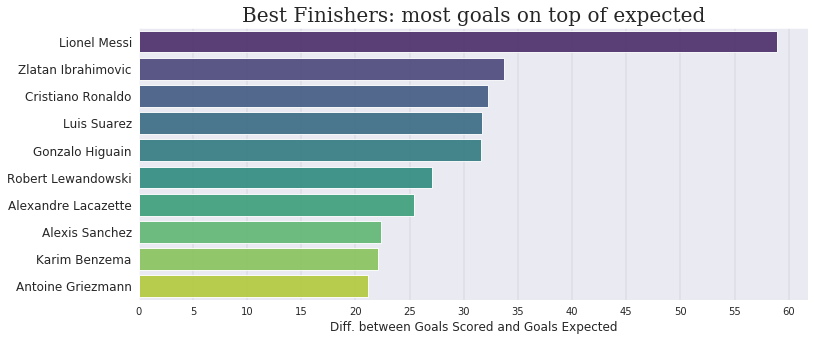

In [38]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=abs(show['difference']), y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,65,5))
ax.set_xlabel(xlabel='Diff. between Goals Scored and Goals Expected', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: most goals on top of expected", fontsize=20, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
plt.show()

毫不奇怪，我们可以看到**Messi**在这个指标上比其他人好得多。根据他所有射门的次数和特点，他本应打进146球，但他却进了205球。不出所料，我们在榜单上找到的都是世界级的著名球员。

请记住，我们在这里看到的是绝对值，即总目标。让我们看看当我们看进球得分/期望得分比率时会发生什么。我们只保留进球总数超过30个的球员（数据涵盖了8年的时间跨度，因此30个进球并不多）。

In [39]:
show = players[players['trueGoals']>30].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'ratio', 'trueGoals', 'expectedGoals']].head(10)
show.head(5)


,rank,player,ratio,trueGoals,expectedGoals
0,1,Franck Ribery,1.892148,40,21.14
1,2,Mario Gotze,1.584582,37,23.35
2,3,Bas Dost,1.549720,36,23.23
3,4,Heungmin Son,1.520913,32,21.04
4,5,Luis Suarez,1.492073,96,64.34


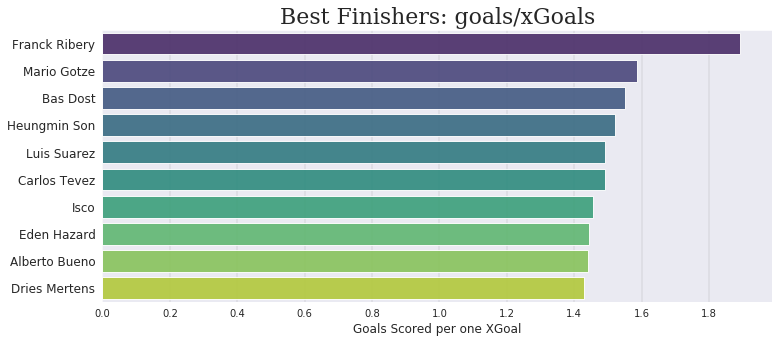

In [40]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,1.9,0.2))
ax.set_xlabel(xlabel='Goals Scored per one XGoal', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: goals/xGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

我们发现**Ribery**是比赛中最高产的终结者。这个指标的一个优点是它很容易解释。它对应于球员得分的比例，与如果他像普通球员一样射门的话他会进多少球相对应。在**Ribery**的例子中，根据他射门的次数，他每进一球就应该得分，但他几乎进了两球。

### 每赛季每个联赛的最佳终结者

在我们的数据中，谁是每个赛季中最好的终结者？

In [41]:
players_per_year = shots.groupby(['year', 'country', 'player']).sum().reset_index()
players_per_year.rename(columns={'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
players_per_year.expectedGoals = round(players_per_year.expectedGoals,2)
players_per_year.difference = round(players_per_year.difference,2)
players_per_year['ratio'] = players_per_year['trueGoals'] / players_per_year['expectedGoals']
players_per_year['ratio'] = round(players_per_year.ratio, 2)

In [42]:
def best_finishers_per_year(years, leagues, min_goals, df):
    years_res=[]; leagues_res=[]; players_res=[]; ratio_res=[]; goals=[]
    players_per_year = df[df['trueGoals']>min_goals]
    for league in leagues:
        for year in years:
            results = players_per_year[(players_per_year['year']==year) & (players_per_year['country']==league)].sort_values(by='ratio', ascending=False).reset_index(drop=True)
            results['rank'] = results.index + 1
            if len(results)>0:
                years_res.append(year)
                leagues_res.append(league)
                players_res.append(results[results['rank']==1]['player'].iloc[0])
                ratio_res.append(results[results['rank']==1]['ratio'].iloc[0])
                goals.append(results[results['rank']==1]['trueGoals'].iloc[0])
    return years_res, leagues_res, players_res, ratio_res, goals

In [43]:
years, leagues, players_res, ratio, goals = best_finishers_per_year(years = players_per_year.year.unique(), leagues=players_per_year.country.unique(),\
                       min_goals=12, df=players_per_year)

In [44]:
results_perYear = pd.DataFrame()
results_perYear['League']=leagues
results_perYear['Year']=years
results_perYear['bestFinisher']=players_res
results_perYear['Goals']=goals
results_perYear['Goals/xGoals Ratio']=ratio
results_perYear

,League,Year,bestFinisher,Goals,Goals/xGoals Ratio
0,France,2011,Olivier Giroud,13,1.22
1,France,2012,Zlatan Ibrahimovic,18,1.47
2,France,2013,Dario Cvitanich,16,1.69
3,France,2014,Cheick Diabate,13,1.61
4,France,2015,Benjamin Moukandjo,13,1.69
5,France,2016,Zlatan Ibrahimovic,21,2.26
6,Germany,2011,Klaasjan Huntelaar,15,1.78
7,Germany,2012,Martin Harnik,15,1.78
8,Germany,2013,Ivica Olic,13,2.23
9,Germany,2014,Josip Drmic,14,2.03


### 最差终结者
现在，让我们看看评分的另外一侧

In [45]:
show = players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'difference', 'trueGoals', 'expectedGoals']].tail(10)
show.tail(3)

,rank,player,difference,trueGoals,expectedGoals
4784,4785,Mats Hummels,8.91,10,18.91
4785,4786,Amauri,12.00,20,32.00
4786,4787,Jesus Navas,14.51,9,23.51


In [46]:
show = players[players['trueGoals']>30].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show.sort_values(by='rank', ascending=False)
show = show[['rank', 'player', 'ratio', 'trueGoals', 'expectedGoals']].head(10)
show.head(3)

,rank,player,ratio,trueGoals,expectedGoals
140,141,Giampaolo Pazzini,0.782038,31,39.64
139,140,Mario Balotelli,0.812641,36,44.30
138,139,Gonzalo Bergessio,0.845608,31,36.66


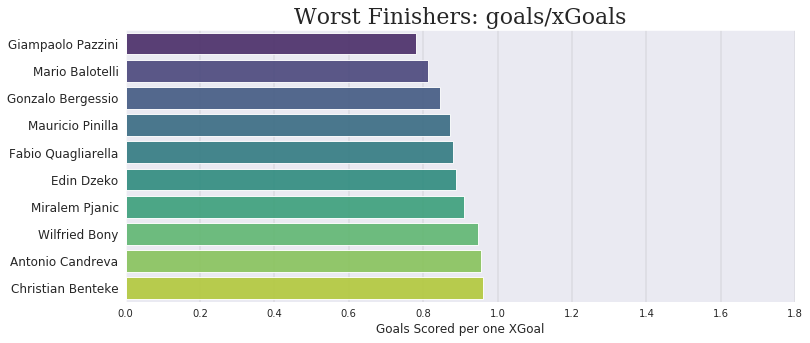

In [47]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,1.9,0.2))
ax.set_xlabel(xlabel='Goals Scored per one XGoal', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Worst Finishers: goals/xGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()


我们发现像**Mario Balotelli**, **Giampaolo Pazzini**、或**Edin Dzeko**等球员的进球比他们应有的少得多**Giampaolo Pazzini**实际上在这两个名单上（目标和trueGoals/xGoals比率的绝对差异）。

看着进球比预期少很多的球员是很有趣的。这有点告诉我们，这些球员错过了太多的机会，应该提高他们的射门命中率。但这也意味着他们在那里创造了比最广泛的数据（比如*goals*）告诉我们的更多的得分机会。因此，从这个意义上说，他们被低估了。

## 3.b) 哪名球员有最多的预期进球？

为此，我们只需按*expectedGoals*顺序排列结果。正如我们的模型所预测的那样，它告诉我们，根据他们拥有的所有机会，哪些球员应该进球最多。

In [48]:
show = players[['player', 'trueGoals', 'expectedGoals']].sort_values(['expectedGoals'], ascending=False).head(10)
show.head(5)

,player,trueGoals,expectedGoals
944,Cristiano Ronaldo,198,165.73
2745,Lionel Messi,205,146.13
4779,Zlatan Ibrahimovic,153,119.29
1277,Edinson Cavani,121,113.93
3971,Robert Lewandowski,124,96.97


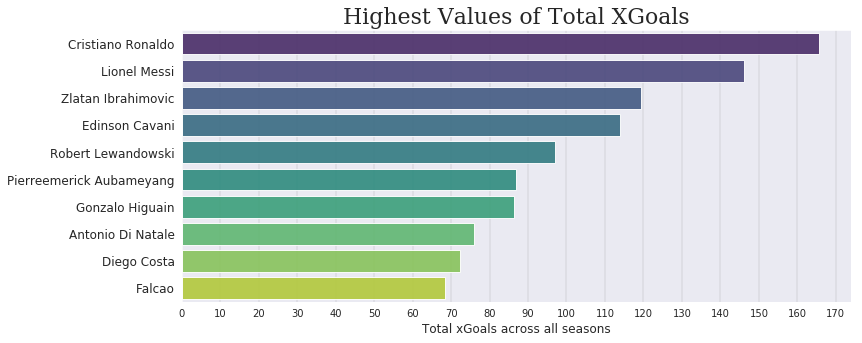

In [49]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['expectedGoals'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,180,10))
ax.set_xlabel(xlabel='Total xGoals across all seasons', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Highest Values of Total XGoals", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

## 3.c) 哪名球员有最差的射门选择？

通过研究球员的总预期目标和他们尝试射门的总次数之间的关系，我们可以确定哪些球员做出了最糟糕的射门决定。也就是说，他们总是倾向于不太可能最终成为目标的射门。我们将只选择至少射门100次的球员。

In [50]:
# Because event_type is always one in our data, we can use it its sum as the total number of shots each player took.
players.rename(columns={'event_type': 'n_shots'}, inplace=True)

In [51]:
players['xG_per_shot_ratio'] = players['expectedGoals'] / players['n_shots']
show = players[players['n_shots']>100].sort_values(['xG_per_shot_ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'xG_per_shot_ratio', 'trueGoals', 'expectedGoals', 'difference']].tail(5)


,rank,player,xG_per_shot_ratio,trueGoals,expectedGoals,difference
669,670,Daniel Baier,0.042316,5,7.49,2.49
670,671,Ivan Radovanovic,0.041491,2,6.68,4.68
671,672,Florent Balmont,0.036786,5,6.18,1.18
672,673,Gokhan Inler,0.035622,9,6.59,-2.41
673,674,Tom Huddlestone,0.030463,2,3.29,1.29



**Gohhan Inler**和**Ruben Rochina**的案例非常有趣。他们似乎尝试了很多远射，但看起来他们实际上也很擅长。看看他们的实际进球和预期进球之间的差异：尽管他们射了“糟糕”的球，但他们的得分比预期的要多。因此，在他们的情况下，做出这样的决定可能并不是一个糟糕的决定。

另一方面，我们也有类似**Ivan Radovanovic**的案例。他也在不太可能的位置上射了很多球，而且他似乎并不擅长，因为他只有两个进球，而他的预期目标是6.6。这些射门也可能发生在角球后的情况下，球员有时从很远的地方向任何方向射门，没有任何进球的希望，而是让球出去重新组织防守。所以也许这些糟糕的镜头在某种程度上是有意义的，我们不应该对它如此残忍。

在列表的底部，我们找到了那些倾向于从禁区内或近距离射门的球员。正如我们所料，这里我们发现的主要是前锋和目标球员，他们往往在对方球门附近射门。

***Diego Milito**, **Kevin Gameiro**、以及**Carlos Bacca**都是这些球员。例如，迭戈·米利托的平均射门得分为0.21，这意味着，根据我们的模型，平均而言，他每一次射门都有超过20%的机会进球。换句话说，看起来他只射了好的/安全的一球，没有冒太大的风险。

In [52]:
show = show[['rank', 'player', 'xG_per_shot_ratio', 'trueGoals', 'expectedGoals', 'difference']].head(10)
show.head(5)

,rank,player,xG_per_shot_ratio,trueGoals,expectedGoals,difference
0,1,Diego Milito,0.208913,33,28.83,-4.17
1,2,Kevin Gameiro,0.193564,63,58.65,-4.35
2,3,Ikechukwu Uche,0.193009,21,21.81,0.81
3,4,Carlos Bacca,0.191565,57,44.06,-12.94
4,5,Dario Cvitanich,0.190690,30,22.12,-7.88


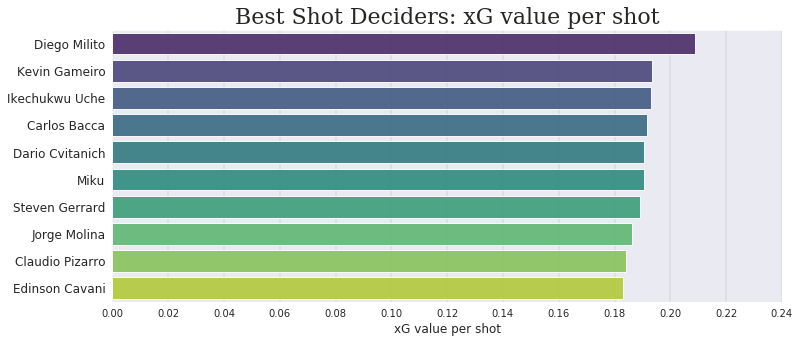

In [53]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=show['xG_per_shot_ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,0.25,0.02))
ax.set_xlabel(xlabel='xG value per shot', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Shot Deciders: xG value per shot", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

## 3.d) 谁的头球最好?

In [54]:
headers = shots[(shots.event_type==1) & (shots.bodypart==3)]
headers_players = headers.groupby('player').sum().reset_index()
headers_players.rename(columns={'event_type': 'n_headers', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
headers_players['ratio'] = headers_players['trueGoals'] / headers_players['expectedGoals']
show_headers = headers_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show_headers['rank'] = show_headers.index+1
show_headers[['rank', 'player', 'n_headers', 'trueGoals', 'expectedGoals', 'difference']].head(5)

,rank,player,n_headers,trueGoals,expectedGoals,difference
0,1,Cristiano Ronaldo,159,36,20.027547,-15.972453
1,2,Mario Mandzukic,124,28,14.710096,-13.289904
2,3,Fernando Llorente,141,25,15.941808,-9.058192
3,4,Sloan Privat,86,17,9.926381,-7.073619
4,5,Pierreemerick Aubameyang,59,14,7.285967,-6.714033


我们看到克里斯蒂亚诺·罗纳尔多是这场比赛中最好的头球手，当他用他的头球进的球数与他用我们的模型应该进的球数相比较时。
前三名的另外两名是马里奥·曼祖基奇和费尔南多·洛伦特。

这很有趣，因为我们可以很容易地看到它如何证实我们所知道的东西。这三个人在头球方面都很出色。

## 3.e) 谁左脚射门最强?

In [55]:
left_foot = shots[(shots.event_type==1) & (shots.bodypart==2)]
left_foot_players = left_foot.groupby('player').sum().reset_index()
left_foot_players.rename(columns={'event_type': 'n_leftFoot_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show_lfoot = left_foot_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show_lfoot['rank'] = show_lfoot.index+1
show_lfoot[['rank', 'player', 'n_leftFoot_shots', 'trueGoals', 'expectedGoals', 'difference']].head(5)

,rank,player,n_leftFoot_shots,trueGoals,expectedGoals,difference
0,1,Lionel Messi,752,167,121.561544,-45.438456
1,2,Antoine Griezmann,345,58,41.403750,-16.596250
2,3,Arjen Robben,296,42,32.090280,-9.909720
3,4,Iago Falque,132,23,13.268173,-9.731827
4,5,Franck Ribery,57,16,6.459363,-9.540637


当然，梅西是第一个登上榜单的。根据射门的特点，与预期相比，他是左脚得分最多的球员。名单上还有安托万·格里兹曼、伊阿戈·法尔克和阿扬·罗本。毫不奇怪，这些球员都是左脚球员。

In [56]:
show_lfoot[show_lfoot.player=='Cristiano Ronaldo'][['rank', 'player', 'expectedGoals', 'trueGoals']]

,rank,player,expectedGoals,trueGoals
79,80,Cristiano Ronaldo,28.421553,32


C罗的左脚进球仍然比我们的模型预期的要多，所以我们可以确认他在左脚射门方面非常出色。但他也不是最好的（他是第80名）。

现在让我们看看当我们看比率而不是总值时会发生什么。

In [57]:
left_foot_players['ratio'] = left_foot_players['trueGoals'] / left_foot_players['expectedGoals']
show_lfoot = left_foot_players[left_foot_players['trueGoals']>20].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show_lfoot['rank'] = show_lfoot.index+1
show_lfoot[['rank', 'player', 'n_leftFoot_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(5)

,rank,player,n_leftFoot_shots,trueGoals,expectedGoals,ratio
0,1,Iago Falque,132,23,13.268173,1.733471
1,2,Mohamed Salah,129,23,13.881466,1.656886
2,3,Lukas Podolski,132,21,13.195219,1.591486
3,4,James Rodriguez,162,23,15.541815,1.479879
4,5,Zlatan Ibrahimovic,129,25,17.275150,1.447165



一些像**Mohamed Salah**这样的新球员现在看起来是非常熟练的左脚终结者。

## 3.f) 谁右脚射门最强?

In [58]:
right_foot = shots[(shots.event_type==1) & (shots.bodypart==1)]
right_foot_players = right_foot.groupby('player').sum().reset_index()
right_foot_players.rename(columns={'event_type': 'n_rightFoot_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show = right_foot_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_rightFoot_shots', 'trueGoals', 'expectedGoals', 'difference']].head(5)

,rank,player,n_rightFoot_shots,trueGoals,expectedGoals,difference
0,1,Luis Suarez,289,69,43.201632,-25.798368
1,2,Gonzalo Higuain,362,86,60.856861,-25.143139
2,3,Alexandre Lacazette,270,70,48.107585,-21.892415
3,4,Zlatan Ibrahimovic,554,111,91.004416,-19.995584
4,5,Robert Lewandowski,378,84,65.436666,-18.563334



我们看到**Luis Suarez**排在榜首**Messi**排在第13位，右脚是他的弱脚，模型没有考虑到这一点，这非常令人惊讶（模型不知道球员是右脚还是左脚，只知道哪只脚是用来射门的）。

我们再次检查比率，而不是总值，以查看是否有不同的结果。

In [59]:
right_foot_players['ratio'] = right_foot_players['trueGoals'] / right_foot_players['expectedGoals']
show_rfoot = right_foot_players[right_foot_players['trueGoals']>20].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show_rfoot['rank'] = show_rfoot.index+1
show_rfoot[['rank', 'player', 'n_rightFoot_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(5)

,rank,player,n_rightFoot_shots,trueGoals,expectedGoals,ratio
0,1,Bas Dost,62,23,13.032646,1.764799
1,2,Carlos Tevez,181,33,19.840784,1.663241
2,3,Franck Ribery,165,24,14.479294,1.657539
3,4,Mario Gotze,170,32,19.902271,1.607857
4,5,Lionel Messi,109,30,18.735735,1.601218



另一个有趣的练习是挑选一些球员，并比较他们在身体各部位完成射门的熟练程度。

让我们以4名顶级球员为例：**Messi**, **Cristiano Ronaldo**, **Zlatan Ibrahimovic**、以及 **Robert Lewandowski**。

In [60]:
right_foot = right_foot_players[right_foot_players['n_rightFoot_shots']>5]
left_foot = left_foot_players[left_foot_players['n_leftFoot_shots']>5]
headers = headers_players[headers_players['n_headers']>5]
all_players = right_foot[['player']].merge(left_foot, on='player', how='inner').merge(headers, on='player', how='inner')                                                                         
all_players_list = list(all_players['player'].unique())

def compare_players(players_list):
    total = right_foot[right_foot['player'].isin(players_list)][['player', 'ratio']]
    total['bodypart']='Right Foot'
    left_foot['bodypart']='Left Foot'
    headers['bodypart']= 'Header'
    total = pd.concat([total, left_foot[left_foot['player'].isin(players_list)][['player', 'ratio', 'bodypart']], headers[headers['player'].isin(players_list)][['player', 'ratio', 'bodypart']]], axis=0)

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=[15,8])
    ax = sns.barplot(y=total['ratio'], x=total['player'], hue=total['bodypart'], palette='viridis', alpha=0.9)
    #ax.set_yticks(np.arange(0,2.2,0.2))
    ax.set_ylabel(ylabel='Goals per xG Ratio', fontsize=14)
    ax.set_xlabel(xlabel='')
    ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=15)
    plt.title("Players Comparison", fontsize=24, fontfamily='serif')
    ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
    plt.legend(fontsize=12)
    plt.show()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


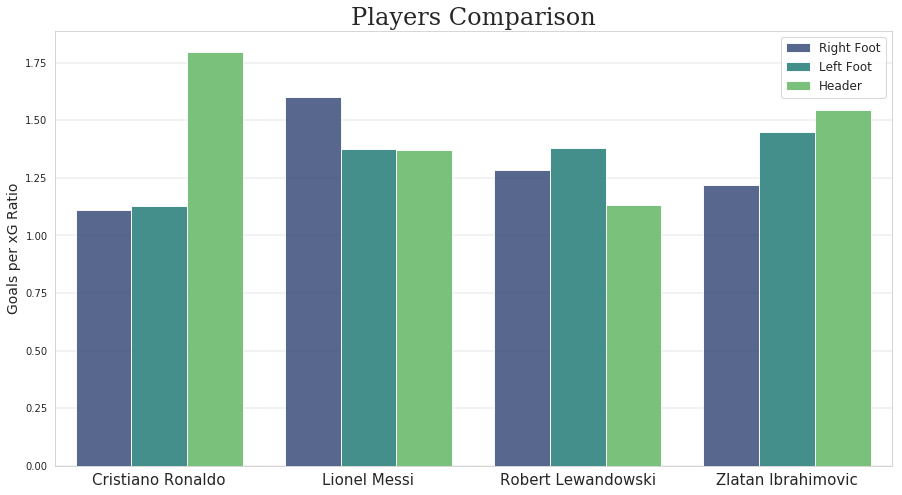

In [61]:
compare_players(players_list = ['Lionel Messi', 'Cristiano Ronaldo', 'Zlatan Ibrahimovic', 'Robert Lewandowski'])

我们看到罗纳尔多是四个中最好的头球，莱万多夫斯基是最差的。梅西是最好的左脚终结者，而兹拉坦似乎是最好的右脚终结者。

值得注意的一件有趣的事情是，所有四名球员的所有身体部位都高于1.0分。这意味着无论是用头部、左脚还是右脚射击，他们都比预期的要好。这是非常令人印象深刻的，并清楚地说明了为什么他们被认为是精英球员。

让我们随机选取四名球员进行比较，以查看对比：

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


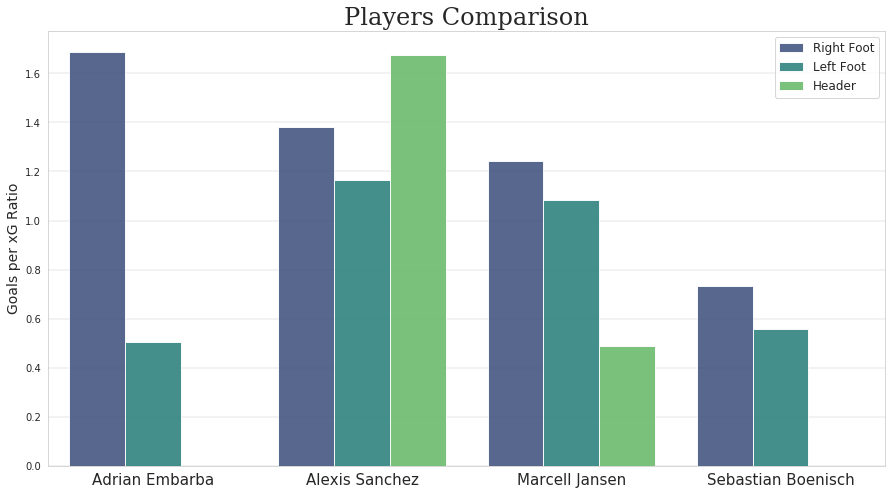

In [62]:
import random
compare_players(random.sample(all_players_list, 4))

我们看到，尽管随机球员可以表现出一些高价值（**Franck Dja Djedje**右脚的比率比之前看到的前四名球员中的任何一位都高），但他们表现出的一致性较差，许多数值低于1.0。也有可能出现高值是因为他们没有很多射门，所以只进一球就可以让指标飞涨。

## 3.g) 谁的远射最强？

In [63]:
outside_box = shots[(shots.location==15)]
outbox_players = outside_box.groupby('player').sum().reset_index()
outbox_players.rename(columns={'event_type': 'n_outbox_shots', 'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
show = outbox_players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_outbox_shots', 'trueGoals', 'expectedGoals', 'difference']].head(5)


,rank,player,n_outbox_shots,trueGoals,expectedGoals,difference
0,1,Lionel Messi,304,16,6.374455,-9.625545
1,2,Paul Pogba,226,14,5.984714,-8.015286
2,3,Zlatan Ibrahimovic,261,14,6.782552,-7.217448
3,4,Gonzalo Higuain,127,11,3.846798,-7.153202
4,5,Yaya Toure,128,10,3.379771,-6.620229


In [64]:
show[['rank', 'player', 'n_outbox_shots', 'trueGoals', 'expectedGoals', 'difference']].tail(5)

,rank,player,n_outbox_shots,trueGoals,expectedGoals,difference
4143,4144,Alberto Aquilani,117,0,3.148452,3.148452
4144,4145,Ronny Rodelin,119,0,3.205746,3.205746
4145,4146,Francesco Lodi,170,0,3.444902,3.444902
4146,4147,Alessandro Diamanti,254,3,6.500314,3.500314
4147,4148,Mario Balotelli,209,1,4.736581,3.736581


 
我们认为**Messi**, **Pogba**和**Zlatan**是在禁区外进球最多的球员，与他们预期的相比。在另一端，我们找到了像**Mario Balotelli**和**Alessandro Diamanti**这样的球员。我很惊讶地看到**Nainggolan**跻身最差（4120位），因为我记得他是一名出色的远距离射手，射入了许多球。但也许那只是因为他尝试了280次射门，而我只记得那些进球。这在很大程度上被证明是一种心理偏见。对于这些情况，最好依靠数字。



再次让我们从trueGoals/xGoals比率的角度来看顶级球员。我们只考虑那些远射超过80次的球员：

In [65]:
outbox_players['ratio'] = outbox_players['trueGoals'] / outbox_players['expectedGoals']
show = outbox_players[outbox_players['n_outbox_shots']>80].sort_values(['ratio', 'trueGoals'], ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'n_outbox_shots', 'trueGoals', 'expectedGoals', 'ratio']].head(10)
show.head(5)

,rank,player,n_outbox_shots,trueGoals,expectedGoals,ratio
0,1,James Rodriguez,105,9,2.419547,3.719704
1,2,Alain Traore,86,6,1.830879,3.277114
2,3,Julian Draxler,94,8,2.612163,3.062596
3,4,Alexandre Lacazette,100,9,2.953207,3.047535
4,5,Yaya Toure,128,10,3.379771,2.958780


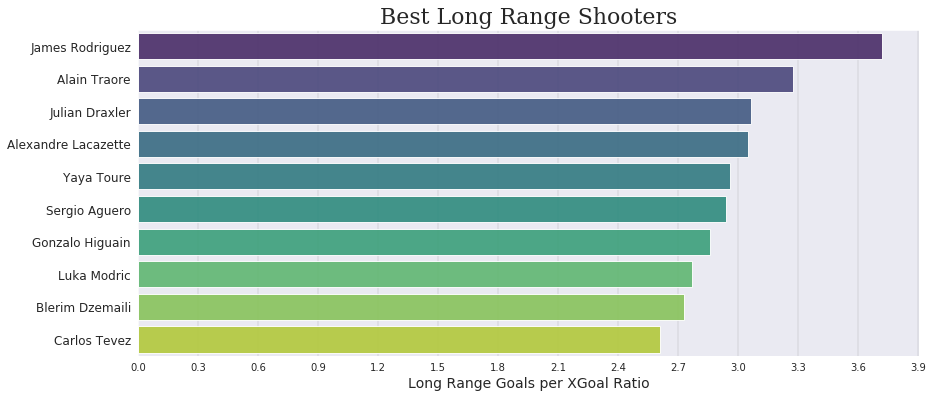

In [66]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[14,6])
ax = sns.barplot(x=show['ratio'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,4,0.3))
ax.set_xlabel(xlabel='Long Range Goals per XGoal Ratio', fontsize=14)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Long Range Shooters", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

看起来 **James Rodriguez** 最厉害了.

## 3.h) 哪位球员的传球最好/危险?

通过观察射门前传球/传球的球员，我们可以评估一名球员通过传球创造了多少xG。

In [67]:
passing = shots[shots.assist_method.isin([1,4])]
passing_players = passing.groupby('player2').sum().reset_index()
passing_players.rename(columns={'player2': 'player', 'event_type': 'n_passes', 'is_goal': 'trueGoals_created', 'prediction': 'expectedGoals_created'}, inplace=True)
show = passing_players.sort_values('expectedGoals_created', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created']].head(5)


,rank,player,n_passes,trueGoals_created,expectedGoals_created
0,1,Lionel Messi,350,68,51.203404
1,2,Mesut Ozil,343,35,36.779472
2,3,Cesc Fabregas,264,53,36.472670
3,4,Zlatan Ibrahimovic,270,36,36.155809
4,5,Marek Hamsik,370,50,34.908642


这有点无聊，但我们再一次发现**Messi**在榜首。在这种情况下，他是通过7年的传球为队友创造了最令人期待的进球的球员。

我们现在可以看看这些传球的平均xG，看看谁是尝试最危险传球的球员。

In [68]:
show['xG_perpass'] = show['expectedGoals_created'] / show['n_passes']
show = show[show['n_passes']>80].sort_values('xG_perpass', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'n_passes', 'xG_perpass']].head(10)
show.head(5)

,rank,player,n_passes,xG_perpass
0,1,Luis Suarez,185,0.165277
1,2,Gareth Bale,109,0.156357
2,3,Angel Di Maria,211,0.151212
3,4,Raul Garcia,90,0.149424
4,5,Lionel Messi,350,0.146295


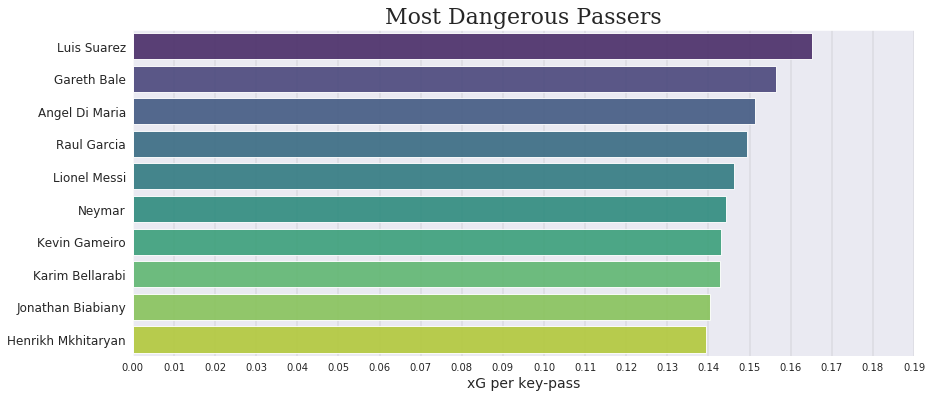

In [69]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[14,6])
ax = sns.barplot(x=show['xG_perpass'], y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,0.2,0.01))
ax.set_xlabel(xlabel='xG per key-pass', fontsize=14)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Most Dangerous Passers", fontsize=22, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='x')
plt.show()

## 3.i) 谁在传球时运气最差?

我们还可以看到谁是传球最不走运的球员。那些传球的预期进球数与实际进球数相差最大的球员。说“不走运”，是因为，与射门的球员不同，另一名球员对他的队友在他精彩的传球后是否能进球不负任何责任！

In [70]:
passing = shots[shots.assist_method.isin([1,4])]
passing_players = passing.groupby('player2').sum().reset_index()
passing_players.rename(columns={'player2': 'player', 'event_type': 'n_passes', 'is_goal': 'trueGoals_created', 'prediction': 'expectedGoals_created'}, inplace=True)
show = passing_players[passing_players['n_passes']>50].sort_values('difference', ascending=False).reset_index(drop=True)
show['rank'] = show.index+1
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created', 'difference']].head(5)

,rank,player,n_passes,trueGoals_created,expectedGoals_created,difference
0,1,Joan Verdu,134,7,14.553249,7.553249
1,2,Xabi Prieto,152,6,13.248345,7.248345
2,3,Philippe Coutinho,177,13,19.868715,6.868715
3,4,Luca Cigarini,164,6,12.789593,6.789593
4,5,Alejandro Gomez,137,5,11.720853,6.720853


In [71]:
show[['rank', 'player', 'n_passes', 'trueGoals_created', 'expectedGoals_created', 'difference']].tail(5)

,rank,player,n_passes,trueGoals_created,expectedGoals_created,difference
686,687,Marek Hamsik,370,50,34.908642,-15.091358
687,688,Cristiano Ronaldo,222,45,29.240792,-15.759208
688,689,Cesc Fabregas,264,53,36.472670,-16.527330
689,690,Karim Benzema,214,40,23.340346,-16.659654
690,691,Lionel Messi,350,68,51.203404,-16.796596


可以看到名单的底部是来自最强球队的球员。这是有道理的，因为他们的队友通常都很好，所以他们被期望能获得为他们创造的机会。

在榜首，我们也看到了一些著名的“不幸”球员，比如**Philippe Coutinho**和**Eden Hazard**，根据他们为球队创造的机会，他们的“助攻”数据应该更高。这并没有对2011年至2016年在利物浦或切尔西的队友给予高度评价。换句话说，如果他们的队友至少以平均效率完成这些比赛，那么**Philippe Coutinho**和**Eden Hazard**在这些赛季都会得到比官方数据更多的助攻。